In [ ]:
!pip install cesium

In [ ]:
!pip install sncosmo

In [ ]:
!pip install seaborn

In [ ]:
!pip install PyWavelets

In [ ]:
!pip install schwimmbad

In [1]:
import os
import numpy as np
import scipy.stats as spstat
import matplotlib.pyplot as plt
from collections import OrderedDict
import sncosmo
from astropy.table import Table
import pywt
import pywt.data
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plot
import sys
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
fromgoogle = False
if fromgoogle == True:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
#Ler uma tabela astropy
filename='training_set.csv'
training_data = Table.read(filename, format='ascii.csv')

In [5]:
print(training_data.info)
print(training_data)

<Table length=1421705>
   name    dtype 
--------- -------
object_id   int64
      mjd float64
 passband   int64
     flux float64
 flux_err float64
 detected   int64

object_id    mjd     passband     flux      flux_err detected
--------- ---------- -------- ------------ --------- --------
      615 59750.4229        2  -544.810303  3.622952        1
      615 59750.4306        1  -816.434326   5.55337        1
      615 59750.4383        3  -471.385529  3.801213        1
      615  59750.445        4  -388.984985 11.395031        1
      615  59752.407        2  -681.858887  4.041204        1
      615 59752.4147        1 -1061.457031  6.472994        1
      615 59752.4224        3   -524.95459  3.552751        1
      615 59752.4334        4  -393.480225  3.599346        1
      615 59752.4435        5   -355.88678 10.421921        1
      615 59767.2968        2   -548.01355  3.462291        1
      ...        ...      ...          ...       ...      ...
130779836  60537.147      

In [6]:
#Ler uma tabela astropy
filename='training_set_metadata.csv'
meta_training = Table.read(filename, format='ascii.csv')
nobjects = len(meta_training)

In [7]:
print(meta_training.info)

<Table length=7848>
       name         dtype  n_bad
------------------ ------- -----
         object_id   int64     0
                ra float64     0
              decl float64     0
             gal_l float64     0
             gal_b float64     0
               ddf   int64     0
     hostgal_specz float64     0
    hostgal_photoz float64     0
hostgal_photoz_err float64     0
           distmod float64  2325
             mwebv float64     0
            target   int64     0



In [8]:
print(meta_training)

object_id     ra        decl      gal_l    ... distmod mwebv target
--------- ---------- ---------- ---------- ... ------- ----- ------
      615 349.046051 -61.943836  320.79653 ...     nan 0.017     92
      713  53.085938 -27.784405 223.525509 ... 45.4063 0.007     88
      730  33.574219  -6.579593 170.455585 ... 40.2561 0.021     42
      745   0.189873 -45.586655 328.254458 ... 40.7951 0.007     90
     1124 352.711273 -63.823658 316.922299 ... 40.4166 0.024     90
     1227  35.683594  -5.379379 171.992947 ...     nan  0.02     65
     1598  347.84671 -64.760857 318.929827 ... 39.7279 0.019     90
     1632 348.595886  -63.07262 320.023289 ... 43.1524 0.021     42
     1920 149.414062   3.433834 234.919132 ... 41.1401 0.027     90
     1926 149.414062   1.940072 236.565366 ...     nan 0.018     65
      ...        ...        ...        ... ...     ...   ...    ...
130678775 142.734375 -23.480536 254.430952 ... 38.0319 0.056     64
130684460 117.949219  -0.895283 220.752608 ...  

In [9]:
target_vec=np.asarray(meta_training['target'])

In [10]:
unique_targets = np.unique(target_vec)
print ("There are {} unique targets.".format(len(unique_targets)))
print (unique_targets)

There are 14 unique targets.
[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


Number of objects of each class
[   0.  495.  924. 1193.  183.   30.  484.  102.  981.  208.  370. 2313.
  239.  175.]


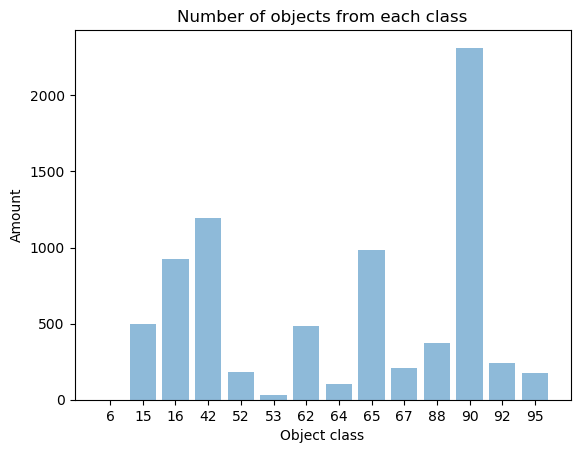

In [11]:
hist_count=np.zeros([len(unique_targets),1])
for i in range (1,len(unique_targets)):
    hist_count[i,0]=np.count_nonzero(target_vec[target_vec==unique_targets[i]])


print('Number of objects of each class')
print(hist_count.ravel())
 
import matplotlib.pyplot as plt; plt.rcdefaults()
objects = ('6', '15', '16', '42', '52', '53', '62','64','65','67','88','90','92','95')
y_pos = np.arange(len(objects))
performance = hist_count.ravel()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amount')
plt.xlabel('Object class')
plt.title('Number of objects from each class') 
plt.show()

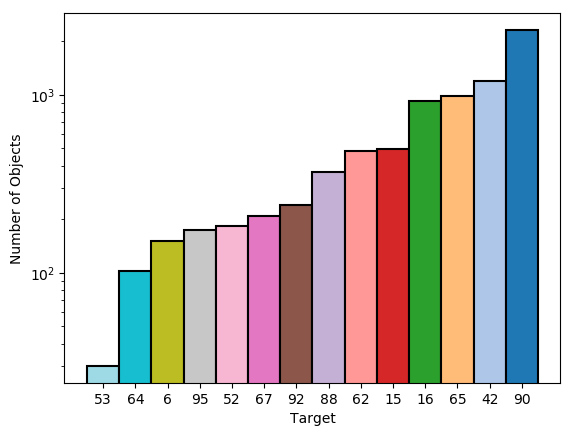

In [12]:
counts = Counter(meta_training['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))


cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
plt.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
plt.xlabel('Target')
plt.ylabel('Number of Objects')
plt.show()

Dict das bandas passantes

In [13]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

Criar as timeseries com o cesium

In [14]:
import ipywidgets

tsdict = OrderedDict() #time series dict

for i in tnrange(nobjects, desc='Building Timeseries'):
    row = meta_training[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (training_data['object_id'] == thisid)
    thislc = training_data[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del training_data

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdCdWlsZGluZyBUaW1lc2VyaWVzJywgbWF4PTc4NDgsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHTigKY=


In [15]:
#print('Famílias de wavelets disponíveis')
#print(pywt.wavelist())

In [16]:
'''
À trous wavelet transform é esta!!!!!! https://pywavelets.readthedocs.io/en/latest/ref/swt-stationary-wavelet-transform.html
'''
# Criar o objeto wavelet
w = pywt.Wavelet('sym2')
#calculo que a família de wavelets que escolhi seja a symlet, pelo nome, e que é uma two level wavelet transform, mas confirmar

In [17]:
print(w)

Wavelet sym2
  Family name:    Symlets
  Short name:     sym
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [18]:
space_times = []
space_measurements = []
space_errors = []
for index in tsdict:
  n_channels = tsdict[index].n_channels
  space_times.append([t for t in tsdict[index].time])
  #space_measurements.append([pywt.wavedec(m, pywt.Wavelet("sym2"), level=n_channels) for m in tsdict[index].measurement])
  space_measurements.append([m for m in tsdict[index].measurement])
  space_errors.append([e for e in tsdict[index].error])

#print(space_times)
#print("\n")
#print(space_measurements)
#print("\n")
#print(space_errors)

#Sample code
#n_channels = tsdict[615].n_channels
#space["times"] = [t for t in tsdict[615].time]
#space["dwts"] = [pywt.wavedec(m, pywt.Wavelet("sym2"), level=n_channels) for m in tsdict[615].measurement]
#space["errors"] = [e for e in tsdict[615].error]
#fset_dwt = featurize.featurize_time_series(times=None, values=space["dwts"], errors=None, meta_features=tsdict[615].meta_features)
#fset_nowave = featurize.featurize_time_series(times=space["times"])
#print(fset_dwt.head())
#space["times"]
#for m in tsdict[615].measurement:
  #print((m))
    
print(len(space_times))
print(len(space_measurements))
print(len(space_errors))

7848
7848
7848


In [19]:
space_meta_features = []
for index in tsdict:
  space_meta_features.append(tsdict[index].meta_features)
print(len(space_meta_features))

7848


In [20]:
import pickle              # import module first

f = open('space_times.p', 'w')   # Pickle file is newly created where foo1.py is
pickle.dump(space_times, f, -1)          # dump data to f
f.close()
f = open('space_measurements.p', 'w')   # Pickle file is newly created where foo1.py is
pickle.dump(space_measurements, f, -1)          # dump data to f
f.close()
f = open('space_errors.p', 'w')   # Pickle file is newly created where foo1.py is
pickle.dump(space_errors, f, -1)          # dump data to f
f.close()

In [21]:
space_meta_features = []
for index in tsdict:
    print (index)
    space_meta_features.append(tsdict[index].meta_features)

print(len(space_meta_features))

615
713
730
745
1124
1227
1598
1632
1920
1926
2072
2103
2300
2330
2624
2677
2922
3041
3285
3423
3489
3910
4088
4132
4171
4173
4220
4389
4595
4819
5527
6180
6266
6762
6947
7033
7164
7315
7409
7566
7698
7703
7756
8328
8688
8745
8784
9006
9172
9184
9203
9543
9936
9985
10321
10337
10349
10478
10586
10757
10796
10798
11165
11359
11507
11770
11773
11931
11978
12695
12872
13079
13138
13194
13459
13482
13504
14080
14156
14279
14398
14539
14553
14601
14674
14983
15002
15251
15475
15626
15674
15700
15718
15845
15968
16339
16349
16463
16496
16802
16983
17094
17172
17285
17366
17370
17515
18029
18507
18556
18645
18706
18937
18952
19154
19213
19866
20567
20934
21335
22184
22574
22901
23116
23127
23299
23373
23396
23409
23539
23795
23822
23848
23857
23931
24193
24236
24592
24849
24903
24947
24989
25003
25039
25474
25529
25577
25783
25920
25925
26161
26338
26352
26401
26531
26660
26783
27124
27339
27941
28220
28301
28391
28636
28843
28915
29088
29252
29416
29420
29576
29668
29670
30066
30172
30191
30

235022
235124
235141
235219
235402
235478
235641
235847
235952
235970
236075
236095
236106
236205
236222
236386
236647
236699
237006
237146
237149
237164
237313
237559
237600
237651
237982
238011
238195
238279
238409
238484
238604
238605
238809
239050
239080
239227
239315
239328
239364
239835
240038
240293
240336
240399
240759
240999
241329
241393
241412
241746
241980
242132
242450
242508
242522
242834
242943
242991
243303
243320
243552
243726
243928
244159
244228
244487
244614
244733
244805
244952
245078
245390
245457
245506
245571
245610
245807
245853
245887
245974
246012
246096
246195
246247
246511
246759
246768
246788
246789
247109
247729
247738
247781
247906
248046
248547
248648
248925
248938
249296
249825
249956
249983
249991
250218
250327
250572
250871
250956
251002
251079
251430
251728
252115
252136
252193
252245
252381
252543
252575
252610
252646
252924
253015
253072
253105
253231
253395
253633
253634
253796
253844
253860
254082
254147
254238
254305
254314
254469
254618
254732

14619652
14624104
14643532
14650534
14691393
14698897
14705653
14708119
14721928
14739524
14810920
14855523
14888486
14904492
14906834
14958598
14962316
14979611
14982938
14988203
15060380
15071717
15072535
15091832
15173836
15208766
15216825
15225240
15232338
15277248
15284512
15319288
15322511
15339689
15350467
15394758
15406344
15428492
15428693
15444354
15494091
15498575
15500040
15514596
15541983
15579224
15588716
15600667
15603210
15630591
15650617
15692376
15697118
15702122
15703151
15704679
15723500
15727305
15733808
15741784
15751675
15758096
15761447
15795242
15797803
15858721
15897952
15926229
15926420
15929116
15980885
16006344
16067266
16081303
16128233
16173841
16196888
16203250
16241872
16303031
16382436
16390872
16427062
16439973
16452890
16461833
16464556
16477535
16487008
16494640
16501517
16504681
16576079
16591957
16598333
16651214
16660550
16676333
16755032
16763588
16775731
16780730
16791483
16820233
16829513
16889337
16907701
16979142
17010401
17011351
17064403
1

49428124
49519074
49536340
49551838
49575267
49589687
49611669
49620169
49626003
49679459
49686525
49748338
49766404
49776390
49783859
49789340
49816903
49850869
49875529
49896733
49950170
49983452
50025191
50031767
50036828
50049510
50061624
50088147
50089586
50107953
50118260
50120717
50120780
50136410
50150449
50154052
50198556
50217109
50218120
50228511
50233326
50253232
50382323
50384532
50420178
50423372
50429346
50445945
50483812
50538474
50571533
50669045
50700718
50774437
50787617
50875482
50926314
50935885
50941150
50949719
50952355
50957767
50979853
50996359
51008084
51053939
51055844
51091661
51106790
51137137
51139333
51139578
51160141
51220364
51232774
51255215
51350200
51352791
51398857
51411523
51416033
51424095
51452175
51452842
51467589
51492407
51493116
51494983
51496907
51503716
51527253
51567112
51571190
51578826
51634841
51680420
51695414
51726360
51729401
51740129
51749817
51775148
51775903
51832424
51833345
51859949
51872509
51897185
51938751
51961807
51964042
5

70972197
70987540
70988624
71035086
71037110
71066710
71084419
71098197
71104805
71117832
71126328
71132525
71154324
71171595
71188760
71203310
71274152
71290384
71299170
71306733
71323295
71328417
71399090
71421087
71449444
71451908
71459665
71496808
71498812
71503431
71521763
71565997
71620283
71627745
71694096
71717228
71740669
71765133
71816360
71819477
71829905
71843921
71856115
71878650
71928039
71996356
72009300
72040403
72049251
72058012
72065768
72074395
72074915
72088856
72095866
72101996
72123526
72147416
72147688
72162556
72208309
72221625
72242636
72255258
72262779
72273047
72283619
72341756
72361403
72364882
72391044
72568232
72587600
72601841
72639559
72687467
72695878
72722865
72733015
72770043
72796451
72803727
72810857
72853018
72865069
72943445
72982944
73010689
73022626
73029171
73045012
73069741
73077610
73141463
73196956
73287744
73289331
73291580
73338436
73342276
73345291
73367509
73402968
73418931
73428084
73489449
73501891
73501938
73523102
73557446
73569281
7

96596386
96619113
96620553
96628879
96664331
96676197
96687755
96715108
96728510
96755780
96761640
96799174
96854851
96914178
96950346
96975445
97011617
97035078
97072448
97100885
97109451
97110605
97111379
97120903
97128504
97130922
97209370
97214939
97221300
97256645
97285127
97286077
97288684
97293261
97301909
97312508
97321293
97342343
97388897
97411149
97442088
97459034
97529236
97538098
97544837
97546811
97612890
97614844
97639845
97688882
97725738
97736859
97742269
97759814
97765302
97766291
97792190
97835848
97887024
97895407
97906234
97943128
97960909
97998269
98038305
98093823
98118937
98154518
98167067
98191793
98224913
98231865
98261512
98267340
98299516
98307800
98320066
98325702
98357025
98363779
98377483
98448729
98462441
98465677
98491841
98504357
98507931
98510065
98544910
98658462
98671579
98694775
98697164
98714884
98720151
98800009
98807048
98818444
98832629
98840050
98906117
98929706
98977885
99021575
99041421
99108245
99114952
99115883
99158421
99173112
99179619
9

125868406
125889687
125893247
125894120
125995700
126010694
126014103
126019119
126064914
126072689
126078896
126089582
126091280
126141352
126172218
126175029
126185385
126215080
126251981
126252102
126262179
126270180
126308934
126309844
126347345
126367996
126374794
126386017
126400136
126411394
126441371
126463327
126547131
126564408
126576484
126616065
126626855
126633163
126644087
126677682
126686045
126709379
126745808
126780686
126791777
126814460
126863593
126866587
126927279
126976895
126995732
127035076
127087063
127097212
127100219
127145862
127150332
127175591
127189138
127209926
127226794
127227730
127249666
127296295
127333004
127360921
127374613
127378756
127392312
127437349
127521319
127521600
127540625
127570499
127624949
127633216
127634363
127645065
127708254
127717993
127727509
127752560
127779559
127812263
127843563
127884877
127888194
127897121
127928160
127935754
127947078
128010019
128082415
128083908
128089118
128113763
128123284
128149778
128152732
128159801


In [ ]:
#f = open('space_meta_features.p', 'w')   # Pickle file is newly created where foo1.py is
#pickle.dump(space_meta_features, f)          # dump data to f
#f.close()

In [ ]:
import pickle
t = open("space_times.p", 'rb')
space_times = pickle.load(t)
t.close()

m = open("space_measurements.p", 'rb')
space_measurements = pickle.load(m)
m.close()

e = open("space_errors.p", 'rb')
space_errors = pickle.load(e)
e.close()

mf = open("space_meta_features.p", 'rb')
space_meta_features = pickle.load(mf)
mf.close()

In [22]:
print(len(space_times))
print(len(space_measurements))
print(len(space_errors))

7848
7848
7848


In [3]:
import pickle
t = open("mariana/times_with_interp.pickle", 'rb')
space_times = pickle.load(t)
t.close()

m = open("mariana/measures_with_interp.pickle", 'rb')
space_measurements = pickle.load(m)
m.close()


print(len(space_times))
print(len(space_measurements))

ValueError: unsupported pickle protocol: 4

In [2]:
features_to_use = ["all_times_nhist_numpeaks",
                  "all_times_nhist_peak1_bin",
                  "all_times_nhist_peak2_bin",
                  "all_times_nhist_peak3_bin",
                  "all_times_nhist_peak4_bin",
                  "all_times_nhist_peak_1_to_2",
                  "all_times_nhist_peak_1_to_3",
                  "all_times_nhist_peak_1_to_4",
                  "all_times_nhist_peak_2_to_3",
                  "all_times_nhist_peak_2_to_4",
                  "all_times_nhist_peak_3_to_4",
                  "all_times_nhist_peak_val",
                  "avg_double_to_single_step",
                  "avg_err",
                  "avgt",
                  "cad_probs_1",
                  "cad_probs_10",
                  "cad_probs_20",
                  "cad_probs_30",
                  "cad_probs_40",
                  "cad_probs_50",
                  "cad_probs_100",
                  "cad_probs_500",
                  "cad_probs_1000",
                  "cad_probs_5000",
                  "cad_probs_10000",
                  "cad_probs_50000",
                  "cad_probs_100000",
                  "cad_probs_500000",
                  "cad_probs_1000000",
                  "cad_probs_5000000",
                  "cad_probs_10000000",
                  "cads_avg",
                  "cads_med",
                  "cads_std",
                  "mean",
                  "med_double_to_single_step",
                  "med_err",
                  "n_epochs",
                  "std_double_to_single_step",
                  "std_err",
                  "total_time",
                  "amplitude",
                  "flux_percentile_ratio_mid20",
                  "flux_percentile_ratio_mid35",
                  "flux_percentile_ratio_mid50",
                  "flux_percentile_ratio_mid65",
                  "flux_percentile_ratio_mid80",
                  "max_slope",
                  "maximum",
                  "median",
                  "median_absolute_deviation",
                  "minimum",
                  "percent_amplitude",
                  "percent_beyond_1_std",
                  "percent_close_to_median",
                  "percent_difference_flux_percentile",
                  "period_fast",
                  "qso_log_chi2_qsonu",
                  "qso_log_chi2nuNULL_chi2nu",
                  "skew",
                  "std",
                  "stetson_j",
                  "stetson_k",
                  "weighted_average",
                  "fold2P_slope_10percentile",
                  "fold2P_slope_90percentile",
                  "freq1_amplitude1",
                  "freq1_amplitude2",
                  "freq1_amplitude3",
                  "freq1_amplitude4",
                  "freq1_freq",
                  "freq1_lambda",
                  "freq1_rel_phase2",
                  "freq1_rel_phase3",
                  "freq1_rel_phase4",
                  "freq1_signif",
                  "freq2_amplitude1",
                  "freq2_amplitude2",
                  "freq2_amplitude3",
                  "freq2_amplitude4",
                  "freq2_freq",
                  "freq2_rel_phase2",
                  "freq2_rel_phase3",
                  "freq2_rel_phase4",
                  "freq3_amplitude1",
                  "freq3_amplitude2",
                  "freq3_amplitude3",
                  "freq3_amplitude4",
                  "freq3_freq",
                  "freq3_rel_phase2",
                  "freq3_rel_phase3",
                  "freq3_rel_phase4",
                  "freq_amplitude_ratio_21",
                  "freq_amplitude_ratio_31",
                  "freq_frequency_ratio_21",
                  "freq_frequency_ratio_31",
                  "freq_model_max_delta_mags",
                  "freq_model_min_delta_mags",
                  "freq_model_phi1_phi2",
                  "freq_n_alias",
                  "freq_signif_ratio_21",
                  "freq_signif_ratio_31",
                  "freq_varrat",
                  "freq_y_offset",
                  "linear_trend",
                  "medperc90_2p_p",
                  "p2p_scatter_2praw",
                  "p2p_scatter_over_mad",
                  "p2p_scatter_pfold_over_mad",
                  "p2p_ssqr_diff_over_var",
                  "scatter_res_raw"]

In [3]:
import numpy as np
space_times = np.load("st.npy")
space_measurements = np.load('meas.npy')
space_meta_features = np.load('meta.npy')

print(len(space_times))

7848


In [6]:
space_times.tolist()
space_measurements.tolist()
space_meta_features.tolist()

print(len(space_times))

7848


In [7]:
features_interp = []
for index in range(len(space_meta_features)):
    print(index)
    fset = featurize.featurize_time_series(times=space_times[index],
                                           values=space_measurements[index], 
                                           errors=None,
                                           features_to_use=features_to_use,
                                           meta_features=space_meta_features[index])
    features_interp.append(fset)
    
print(len(features_interp))

0


KeyboardInterrupt: 

In [ ]:
import pickle

f = open('features_interp.p', 'wb')   # 'wb' instead 'w' for binary file
pickle.dump(features_interp, f, -1)       # -1 specifies highest binary protocol
f.close()

In [69]:
all_features_set_channel_five = []
for feature in features:
    all_features_set_channel_five.append(np.array(feature)[6])

print(len(all_features_set_channel_five))

#print(len(features))
#(np.array(features[5])[0])

IndexError: index 6 is out of bounds for axis 0 with size 6

In [68]:
import numpy as np
all_features_set_channel_five = np.array(all_features_set_channel_five)
f = open('all_features_set_channel_five.npy', 'wb')   # 'wb' instead 'w' for binary file
np.save(f, all_features_set_channel_five)       # -1 specifies highest binary protocol
f.close()

In [ ]:
f = open('feature_set.p', 'wb')   # 'wb' instead 'w' for binary file
pickle.dump(feature_set, f, -1)       # -1 specifies highest binary protocol
f.close()

In [ ]:
import pickle
t = open("feature_set.p", 'rb')
feature_set = pickle.load(t)
t.close()

In [ ]:
import numpy as np
feature_set = np.array(feature_set)

In [ ]:
f = open('feature_set.npy', 'wb')   # 'wb' instead 'w' for binary file
np.save(f, feature_set)       # -1 specifies highest binary protocol
f.close()

In [ ]:
test = np.load('feature_set.npy')
test

In [2]:
import pickle
f = open('features_new.p', 'rb')
test = pickle.load(f)
f.close()
test[0]

feature,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,linear_trend,medperc90_2p_p,p2p_scatter_2praw,p2p_scatter_over_mad,p2p_scatter_pfold_over_mad,p2p_ssqr_diff_over_var,scatter_res_raw,mwebv,z,zerr
channel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,,,
0,18.0,20.0,0.0,22.0,18.0,1.041379,1.110294,1.659341,1.066176,1.593407,...,0.014427,0.221859,0.155465,0.494340,0.071708,0.696517,0.094340,0.017,0.0,0.0
1,3.0,21.0,42.0,NaN,NaN,1.884615,NaN,NaN,NaN,NaN,...,0.095119,1.133188,0.122995,1.126011,0.182555,1.925987,0.174109,0.017,0.0,0.0
2,3.0,21.0,42.0,NaN,NaN,1.884615,NaN,NaN,NaN,NaN,...,0.076147,1.460207,0.049619,1.119639,0.086228,1.882770,0.119225,0.017,0.0,0.0
3,3.0,21.0,42.0,NaN,NaN,1.884615,NaN,NaN,NaN,NaN,...,0.078759,1.378657,0.048485,1.106351,0.079049,1.824806,0.102021,0.017,0.0,0.0
4,3.0,21.0,42.0,NaN,NaN,1.884615,NaN,NaN,NaN,NaN,...,0.098386,1.099262,0.052893,0.912384,0.082016,1.627768,0.104337,0.017,0.0,0.0
5,4.0,21.0,18.0,42.0,NaN,1.384615,1.800000,NaN,1.300000,NaN,...,0.202550,0.088193,0.051222,0.735849,0.070228,1.628694,0.223287,0.017,0.0,0.0


Para a Gaussian Process Regression

In [ ]:
# Interpolação das light curves usando gaussian process regression 
#from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

#gpdict = OrderedDict() #time series after gaussian process dict
#kernel = DotProduct() + WhiteKernel()
#gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(x,y) #FALTA MUDAR O X E O Y

Para a PCA

In [ ]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)